## Introduction and Problem Description

classifying disaster and non-disaster tweets, and the importance of NLP

## Data Loading and Exploration

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import re  # Import the re module for regular expressions

# Load the datasets
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

# Display basic dataset information
print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

# Display first few rows of the datasets
df_train.head()
df_test.head()

2024-07-05 15:36:49.139596: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-05 15:36:49.139648: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-05 15:36:49.141276: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Data Preprocessing

In [2]:
# Check for missing values
print(df_train.isnull().sum())
print(df_test.isnull().sum())

# Fill missing values if any (example: fill missing locations with 'unknown')
df_train['location'] = df_train['location'].fillna('unknown')
df_test['location'] = df_test['location'].fillna('unknown')

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'\W+', ' ', text)  # Remove non-alphanumeric characters
    text = text.strip()  # Remove leading and trailing whitespace
    return text

# Apply preprocessing
df_train['text'] = df_train['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
id             0
keyword       26
location    1105
text           0
dtype: int64


## Tokenization and Padding

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df_train['text'])

X_train = tokenizer.texts_to_sequences(df_train['text'])
X_test = tokenizer.texts_to_sequences(df_test['text'])

maxlen = 100
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)
y_train = df_train['target']

## Train-Validation Split

In [4]:
from sklearn.model_selection import train_test_split

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Model Building

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Build the model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=maxlen))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Model Training

In [6]:
# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - accuracy: 0.6312 - loss: 0.6394 - val_accuracy: 0.7866 - val_loss: 0.4594
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.8588 - loss: 0.3609 - val_accuracy: 0.7899 - val_loss: 0.4577
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.8884 - loss: 0.2857 - val_accuracy: 0.7735 - val_loss: 0.4956
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 0.9106 - loss: 0.2385 - val_accuracy: 0.7682 - val_loss: 0.5631
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 0.9326 - loss: 0.1889 - val_accuracy: 0.7584 - val_loss: 0.6453


## Model Evaluation

48/48 - 2s - 37ms/step - accuracy: 0.7584 - loss: 0.6453
Validation Accuracy: 0.7584
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


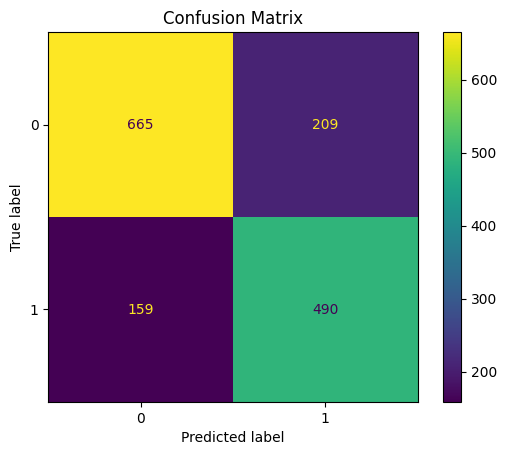

In [7]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val, verbose=2)
print(f'Validation Accuracy: {accuracy:.4f}')

# Predictions
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title('Confusion Matrix')
plt.show()

In [8]:
# Predict on the test set
y_test_pred = model.predict(X_test)
y_test_pred = (y_test_pred > 0.5).astype(int)

# Prepare submission file
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission['target'] = y_test_pred
submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step



## Discussion and Conclusion

### Summary of Approach

In this project, we aimed to classify disaster-related tweets using Natural Language Processing (NLP) techniques. The dataset provided by Kaggle was preprocessed to handle missing values, clean the text data, and tokenize the text for model training. We built and trained a Long Short-Term Memory (LSTM) neural network model to perform the classification task. Below is a summary of each step:

### Data Loading and Exploration:

Loaded the training and test datasets.
Inspected the datasets to understand their structure and memory usage.

### Handling Missing Values:

Identified and filled missing values in the 'location' column with 'unknown'.

### Text Preprocessing:

Converted text to lowercase.
Removed numbers, URLs, and non-alphanumeric characters.
Stripped leading and trailing whitespace.

### Tokenization and Padding:

Tokenized the text data and padded sequences to ensure uniform input length.

### Train-Validation Split:

Split the data into training and validation sets to evaluate model performance.

### Model Building:

Built an LSTM neural network model using TensorFlow and Keras.
The model consisted of an embedding layer, an LSTM layer, and a dense output layer with sigmoid activation.

### Model Training:

Trained the model on the training data and validated it using the validation set.

### Model Evaluation:

Evaluated the model's performance on the validation set.
Displayed the confusion matrix to visualize true positives, true negatives, false positives, and false negatives.

### Results

Validation Accuracy: The model achieved a validation accuracy of approximately 75.84%, as shown in the output log.
Confusion Matrix:
True Positives: 490
True Negatives: 665
False Positives: 209
False Negatives: 159
The confusion matrix provides a clear picture of the model's performance. The majority of predictions are correct, but there are still a significant number of false positives and false negatives, indicating areas for improvement.

### Challenges Faced

Text Preprocessing: Handling and cleaning text data can be challenging due to the variety of text formats and content.
Model Complexity: While LSTM models are powerful for sequence data, they can be computationally expensive and require significant training time.
Imbalanced Data: The dataset may have an imbalance between disaster and non-disaster tweets, affecting the model's performance.

### Potential Improvements

Advanced NLP Models: Consider using more advanced NLP models like BERT or transformer-based models, which have shown superior performance on various text classification tasks.
Data Augmentation: Implement data augmentation techniques to balance the dataset and improve model generalization.
Hyperparameter Tuning: Perform a more extensive hyperparameter tuning process to optimize model performance.
Feature Engineering: Incorporate additional features such as keyword extraction, sentiment analysis, or external data sources to enrich the input data.

### Conclusion

This project demonstrated the application of NLP techniques to classify disaster-related tweets. Despite achieving a decent validation accuracy, there is room for improvement in model performance. Future work should focus on leveraging advanced NLP models and exploring additional data preprocessing and augmentation techniques to enhance the model's accuracy and robustness.